Fetching stock data for 21 tickers...


[*********************100%***********************]  21 of 21 completed


Creating factor features...
Fitting Gaussian Mixture Model with 4 components...
Labeling regimes based on characteristics...
Calculating regime statistics...
Plotting regime probabilities...
Plotting regime characteristics...

=== Market Regime Summary ===
Number of regimes identified: 4

🔹 Inflation Regime (2.6% of time)
  • Description: High inflation indicators
  • Average Return: -0.06%
  • Volatility: 4.16%
  • Duration: 19 days
  • Stability: 73.47%

🔹 Steady State Regime (44.4% of time)
  • Description: Moderate returns, low volatility
  • Average Return: -0.01%
  • Volatility: 0.99%
  • Duration: 326 days
  • Stability: 73.47%

🔹 Steady State Regime (4.1% of time)
  • Description: Moderate returns, low volatility
  • Average Return: -0.46%
  • Volatility: 2.04%
  • Duration: 30 days
  • Stability: 73.47%

🔹 Inflation Regime (49.0% of time)
  • Description: High inflation indicators
  • Average Return: 0.13%
  • Volatility: 0.91%
  • Duration: 360 days
  • Stability: 73.47%

===

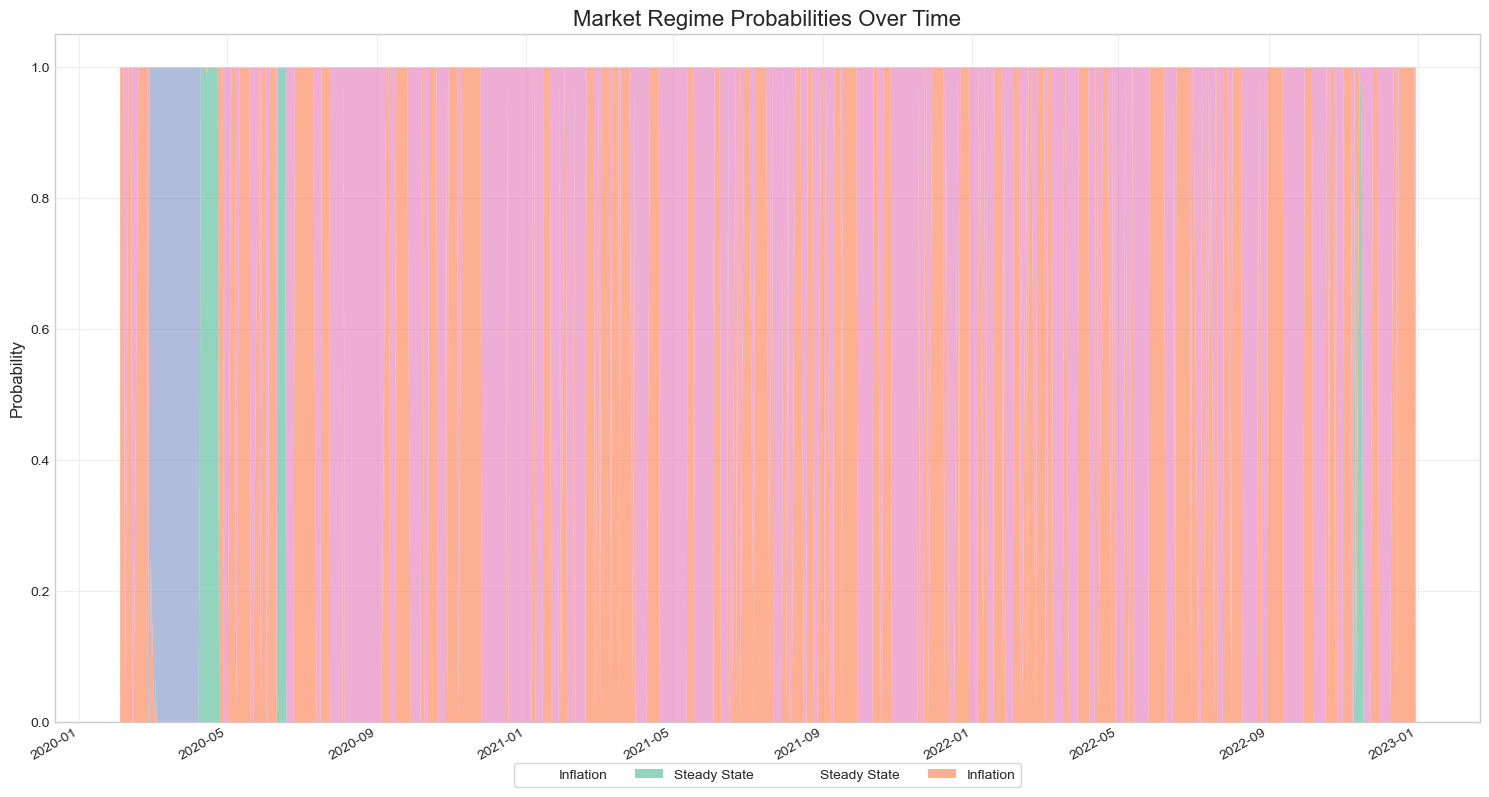

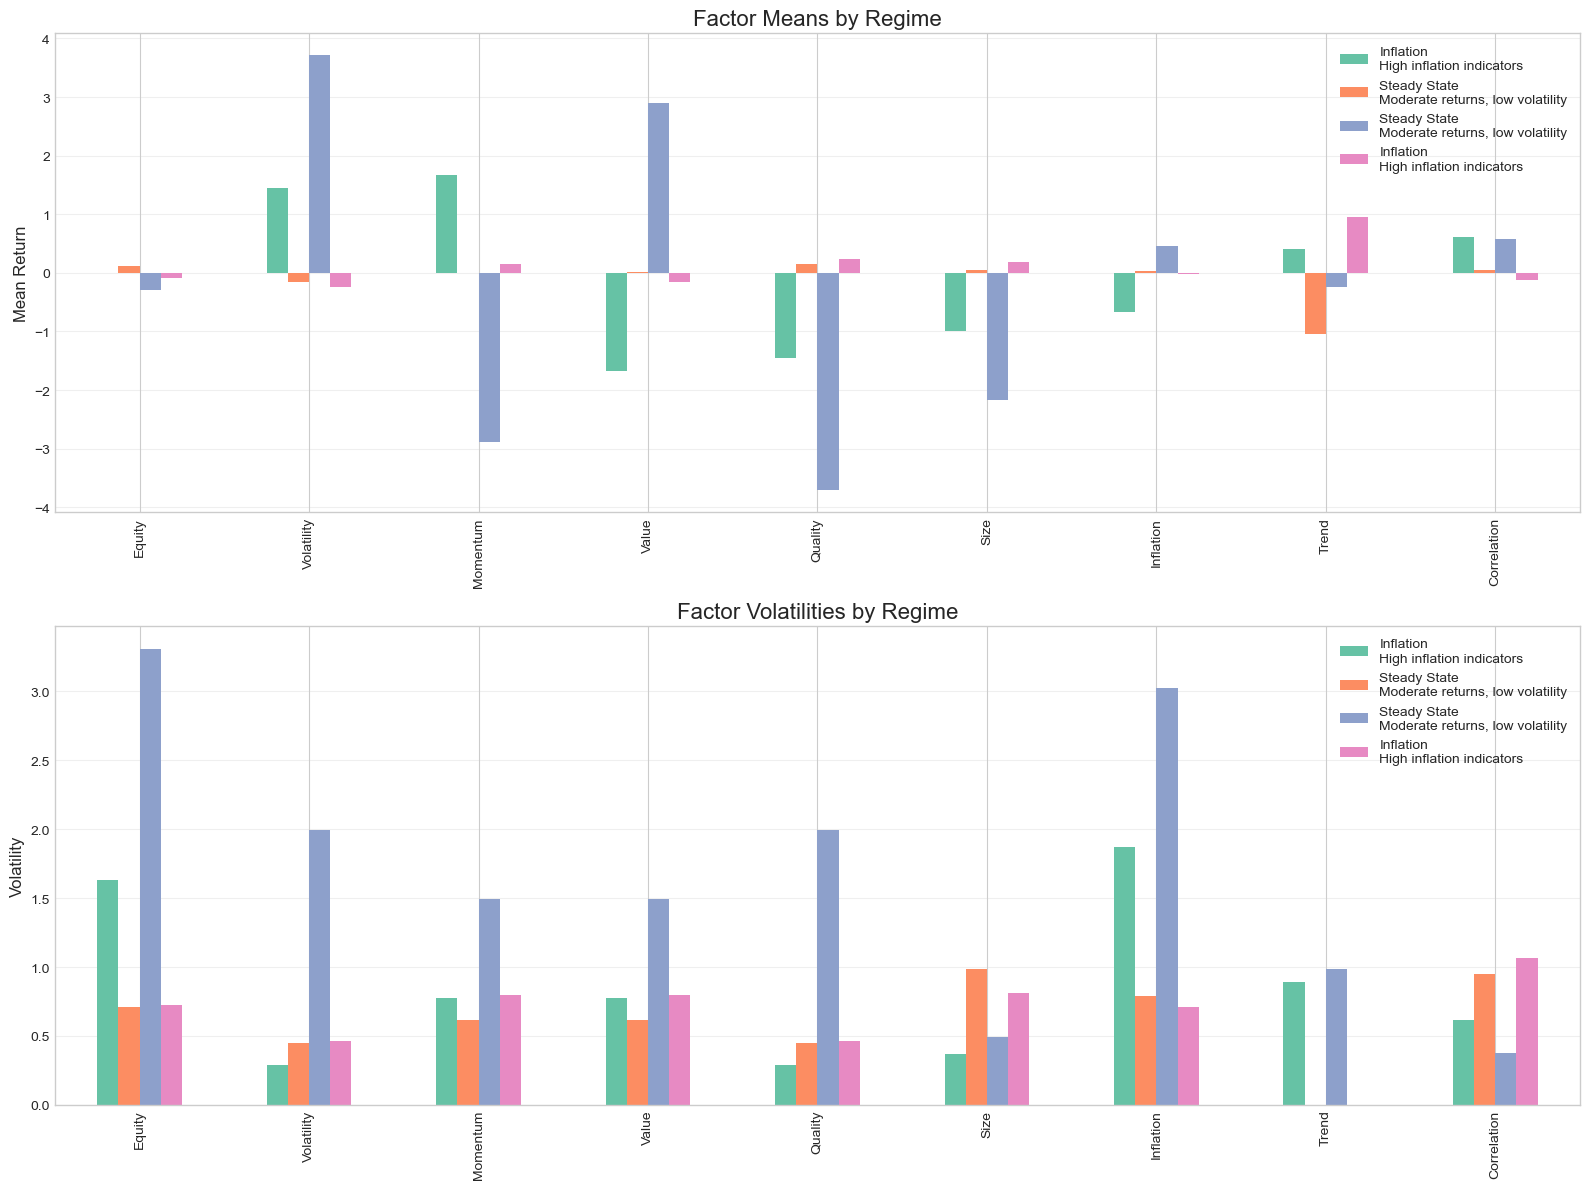

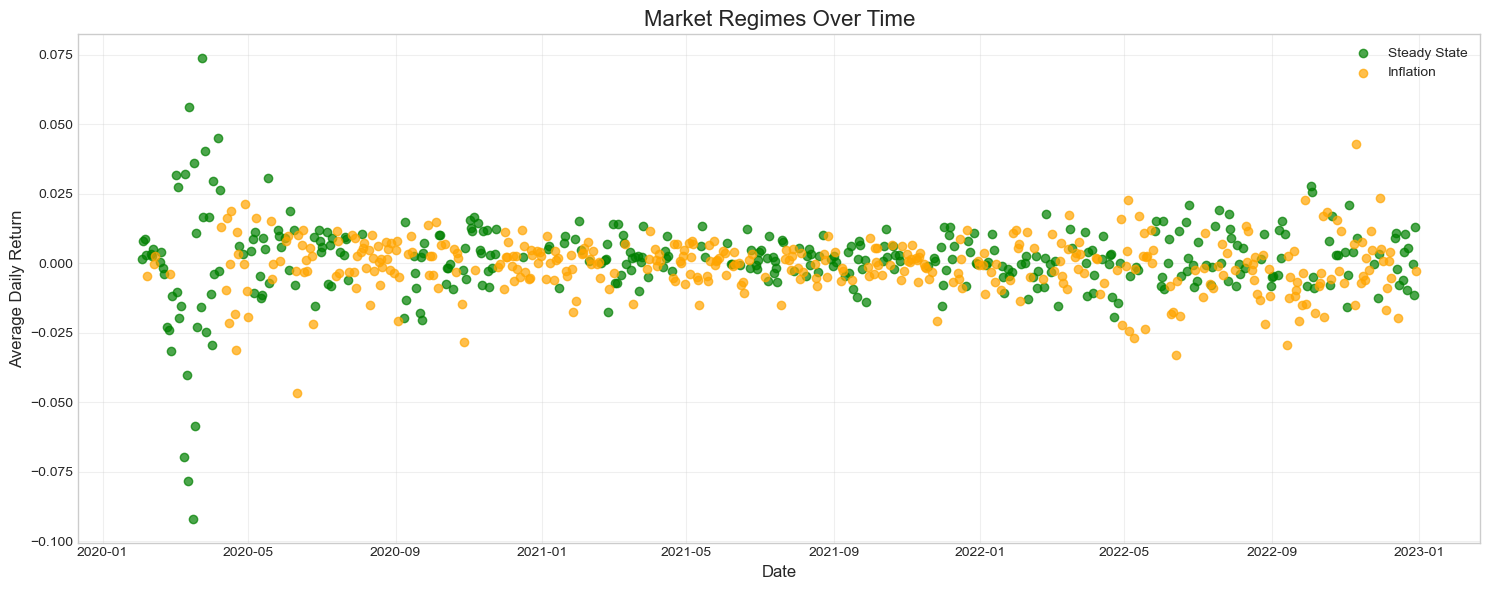

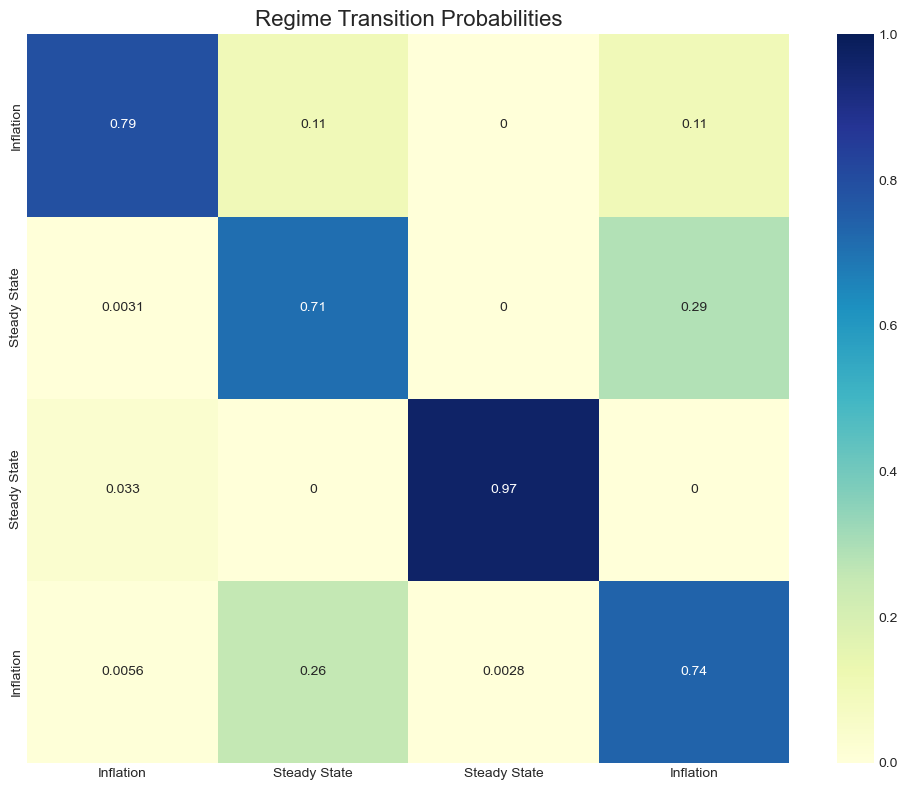

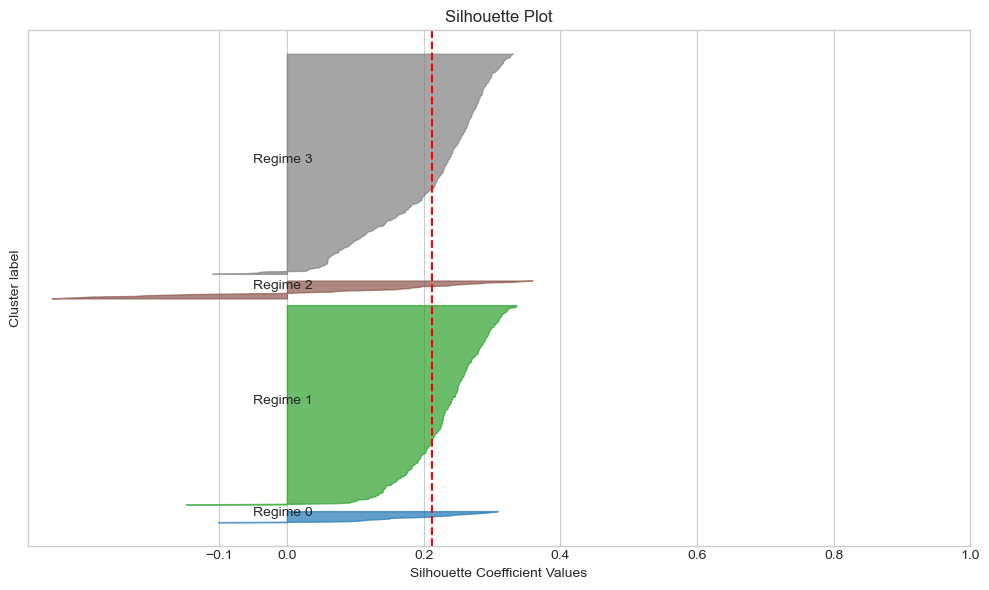

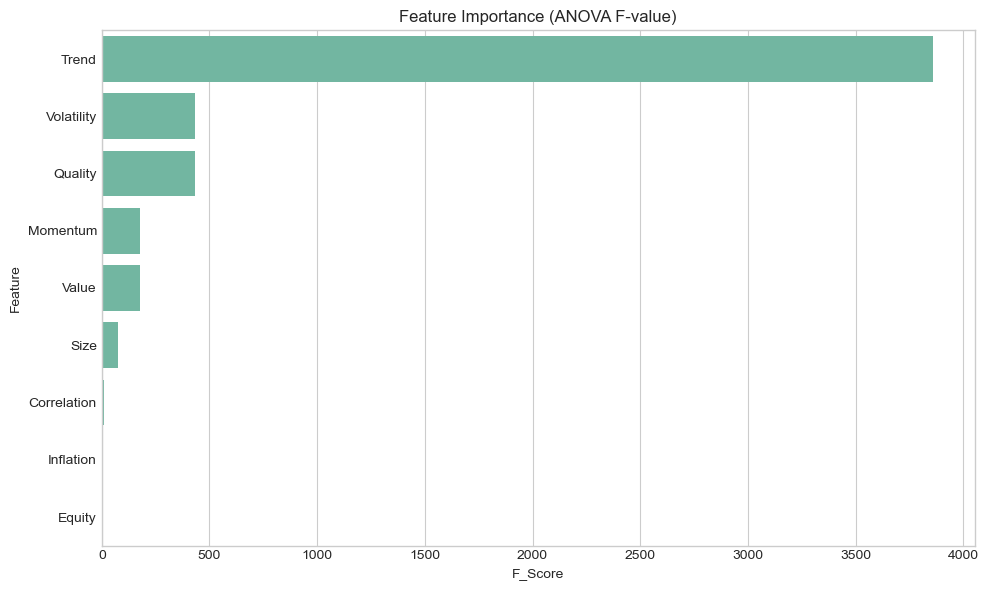

<Figure size 1000x600 with 0 Axes>

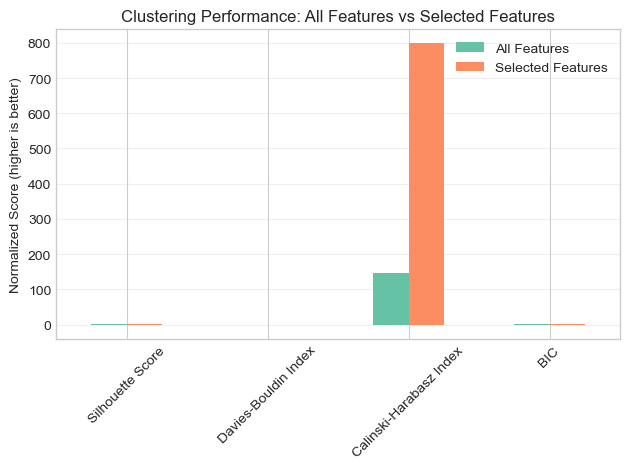

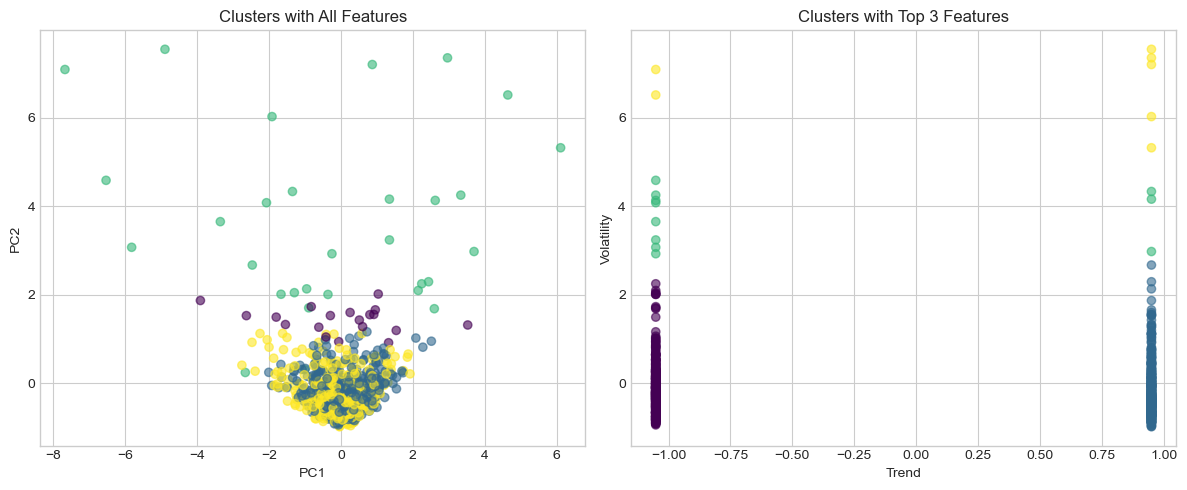

In [59]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.mixture import GaussianMixture
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (silhouette_score, davies_bouldin_score, calinski_harabasz_score, 
                            adjusted_rand_score, silhouette_samples)
from sklearn.feature_selection import f_classif
import yfinance as yf
from datetime import datetime, timedelta
import warnings
warnings.filterwarnings('ignore')

# Set plot style
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette("Set2")

def fetch_stock_data(tickers, start, end):
    #Grab Financial Data
    data = yf.download(tickers, start=start, end=end)["Close"]
    if isinstance(data, pd.Series):
        data = data.to_frame()
    return data.dropna()

def create_factor_features(data, window_short=5, window_long=20):
  
    # Calculate returns
    returns = data.pct_change().dropna()
    
    # Core macro factors
    equity = returns.mean(axis=1)  # Equity factor (market return proxy)
    vol = returns.rolling(window_short).std().mean(axis=1)  # Volatility factor
    
    # Calculate cumulative returns for momentum
    cum_returns = (1 + returns).rolling(window_long).apply(lambda x: x.prod()) - 1
    momentum = cum_returns.mean(axis=1)
    
    # Interest rate proxy using correlations
    corr_matrix = returns.rolling(window_long).corr().dropna()
    avg_correlation = pd.DataFrame()
    
    for date in corr_matrix.index.get_level_values(0).unique():
        avg_correlation.loc[date, 'value'] = corr_matrix.loc[date].values.mean()
    
    # Equity style factors
    # Value proxy (negative of momentum)
    value = -momentum
    
    # Quality (lower volatility)
    quality = -returns.rolling(window_short).std()
    quality = quality.mean(axis=1)
    
    # Size factor (using relative price differences)
    size = pd.Series(index=returns.index)
    for date in returns.index:
        # We'll use price differences as a simple proxy
        if date in data.index:
            size[date] = data.loc[date].std() / data.loc[date].mean()
    
    # Inflation proxy (using rolling return differentials)
    # Positive when returns are accelerating
    inflation = returns.rolling(window_short).mean().mean(axis=1) - \
                returns.rolling(window_long).mean().mean(axis=1)
    
    # Trend following
    trend = pd.Series(index=returns.index, dtype=float)
    for i in range(len(returns) - window_long):
        # Simple trend: positive if recent returns are continuing
        recent_dir = np.sign(returns.iloc[i:i+window_short].mean(axis=1).mean())
        future_dir = np.sign(returns.iloc[i+window_short:i+window_long].mean(axis=1).mean())
        trend.iloc[i+window_long] = 1 if recent_dir == future_dir else -1
    
    # Combine all factors into a dataframe
    factors = pd.DataFrame({
        'Equity': equity,
        'Volatility': vol,
        'Momentum': momentum,
        'Value': value,
        'Quality': quality,
        'Size': size,
        'Inflation': inflation,
        'Trend': trend,
        'Correlation': avg_correlation['value'] if not avg_correlation.empty else pd.Series(dtype=float)
    })
    
    return factors.dropna()

def fit_gaussian_mixture_model(factors, n_components=4, random_state=42):
    # Basing this off of 2Sigma's Approach
    # Scale the features
    scaler = StandardScaler()
    scaled_factors = scaler.fit_transform(factors)
    
    # Fit Gaussian Mixture Model
    gmm = GaussianMixture(
        n_components=n_components,
        covariance_type='full',
        random_state=random_state,
        n_init=10
    )
    gmm.fit(scaled_factors)
    
    # Get regime probabilities and labels
    regime_probs = gmm.predict_proba(scaled_factors)
    regime_labels = gmm.predict(scaled_factors)
    
    # Create DataFrame with probabilities
    regime_df = pd.DataFrame(
        regime_probs, 
        columns=[f'Regime_{i}' for i in range(n_components)],
        index=factors.index
    )
    
    # Add the regime label
    regime_df['regime'] = regime_labels
    
    # Store the means and covariances for later analysis
    regime_means = pd.DataFrame(
        gmm.means_, 
        columns=factors.columns,
        index=[f'Regime_{i}' for i in range(n_components)]
    )
    
    # Calculate volatilities from covariance matrices
    regime_vols = {}
    for i in range(n_components):
        cov = gmm.covariances_[i]
        vols = np.sqrt(np.diag(cov))
        regime_vols[f'Regime_{i}'] = vols
    
    regime_volatilities = pd.DataFrame(
        regime_vols,
        index=factors.columns
    ).T
    
    # Add BIC for model evaluation
    model_info = {
        'BIC': gmm.bic(scaled_factors),
        'n_components': n_components
    }
    
    return {
        'model': gmm,
        'regime_df': regime_df,
        'regime_means': regime_means,
        'regime_volatilities': regime_volatilities,
        'model_info': model_info,
        'scaler': scaler
    }

def label_regimes(regime_means, regime_volatilities):
    labels = {}
    descriptions = {}
    
    for regime in regime_means.index:
        # Analyze the means and volatilities for this regime
        means = regime_means.loc[regime]
        vols = regime_volatilities.loc[regime]
        
        # Check for crisis characteristics
        if means['Equity'] < 0 and vols['Volatility'] > vols['Volatility'].mean():
            labels[regime] = "Crisis"
            descriptions[regime] = "Negative equity returns, high volatility"
        
        # Check for inflation characteristics
        elif means['Inflation'] > means['Inflation'].mean() * 1.5:
            labels[regime] = "Inflation"
            descriptions[regime] = "High inflation indicators"
        
        # Check for "walking on ice" (market fragility)
        elif means['Equity'] > 0 and vols['Volatility'] > vols['Volatility'].mean() * 1.2:
            labels[regime] = "Walking on Ice"
            descriptions[regime] = "Positive but volatile returns"
        
        # Otherwise, steady state
        else:
            labels[regime] = "Steady State"
            descriptions[regime] = "Moderate returns, low volatility"
    
    return labels, descriptions

def calculate_regime_stats(returns_df, regime_labels):
    # Calculate statistics for each regime
    regimes = np.unique(regime_labels)
    stats = {}
    
    # Make sure the returns and regime labels match in length
    returns_mean = returns_df.mean(axis=1)
    
    # Trim to match lengths
    min_length = min(len(returns_mean), len(regime_labels))
    returns_mean = returns_mean.iloc[:min_length]
    regime_labels = regime_labels[:min_length]

    for regime in regimes:
        mask = regime_labels == regime
        regime_returns = returns_mean[mask]

        if len(regime_returns) == 0:
            continue

        avg_return = regime_returns.mean() * 100
        volatility = regime_returns.std() * 100
        duration = mask.sum()

        transitions = np.sum(np.diff(regime_labels) != 0)
        stability = (1 - transitions / len(regime_labels)) * 100

        stats[regime] = {
            "avg_return": avg_return,
            "volatility": volatility,
            "duration": duration,
            "stability": stability
        }

    return stats

def plot_regime_probabilities(regime_df, regime_labels, figsize=(15, 8)):
    # Plot the probability of each regime over time
    fig, ax = plt.subplots(figsize=figsize)
    
    # Stack probabilities
    prob_columns = [col for col in regime_df.columns if col.startswith('Regime_')]
    
    # Replace regime numbers with labels for the legend
    renamed_columns = [regime_labels[col] for col in prob_columns]
    
    regime_df[prob_columns].plot.area(ax=ax, alpha=0.7, linewidth=0)
    
    # Customize plot
    ax.set_title('Market Regime Probabilities Over Time', fontsize=16)
    ax.set_ylabel('Probability', fontsize=12)
    ax.set_xlabel('', fontsize=12)
    ax.legend(renamed_columns, loc='upper center', bbox_to_anchor=(0.5, -0.05),
              ncol=len(prob_columns), frameon=True)
    
    # Add grid
    ax.grid(True, alpha=0.3)
    
    plt.tight_layout()
    return fig

def plot_regime_characteristics(regime_means, regime_volatilities, regime_labels, 
                              descriptions, figsize=(16, 12)):
    # Plotting the characteristics of each regime
    fig, axes = plt.subplots(2, 1, figsize=figsize)
    
    # Plot the means
    regime_means.T.plot(kind='bar', ax=axes[0])
    axes[0].set_title('Factor Means by Regime', fontsize=16)
    axes[0].set_ylabel('Mean Return', fontsize=12)
    axes[0].grid(True, alpha=0.3, axis='y')
    
    # Add regime labels to the x-axis
    new_labels = [f"{regime_labels[idx]}\n{descriptions[idx]}" 
                for idx in regime_means.index]
    axes[0].legend(new_labels)
    
    # Plot the volatilities
    regime_volatilities.T.plot(kind='bar', ax=axes[1])
    axes[1].set_title('Factor Volatilities by Regime', fontsize=16)
    axes[1].set_ylabel('Volatility', fontsize=12)
    axes[1].grid(True, alpha=0.3, axis='y')
    
    # Add regime labels to the x-axis
    axes[1].legend(new_labels)
    
    plt.tight_layout()
    return fig

def analyze_regime_transitions(regime_df):
    # Analyzing transition probabilities between regimes
    # Get regime labels array
    regimes = regime_df['regime'].values
    
    # Count transitions
    max_regime = int(regimes.max())
    transition_counts = np.zeros((max_regime + 1, max_regime + 1), dtype=int)
    
    for i in range(len(regimes) - 1):
        transition_counts[regimes[i], regimes[i+1]] += 1
    
    # Convert to probabilities
    transition_probs = np.zeros_like(transition_counts, dtype=float)
    
    for i in range(transition_counts.shape[0]):
        row_sum = transition_counts[i].sum()
        if row_sum > 0:
            transition_probs[i] = transition_counts[i] / row_sum
    
    # Create DataFrame with regime names for indexes and columns
    regime_names = []
    for i in range(max_regime + 1):
        mask = (regime_df['regime'] == i)
        if mask.any():
            regime_name = regime_df.loc[mask, 'regime_label'].iloc[0]
            regime_names.append(regime_name)
        else:
            regime_names.append(f"Regime_{i}")
    
    transition_df = pd.DataFrame(
        transition_probs,
        index=regime_names,
        columns=regime_names
    )
    
    # Plot heatmap
    plt.figure(figsize=(10, 8))
    sns.heatmap(transition_df, annot=True, cmap="YlGnBu", vmin=0, vmax=1)
    plt.title("Regime Transition Probabilities", fontsize=16)
    plt.tight_layout()
    
    return transition_df

def evaluate_clustering_quality(features, labels):
    # Evaluating clustering quality using appropriate metrics for unsupervised learning
    # Scale features for consistent metric calculation
    scaler = StandardScaler()
    scaled_features = scaler.fit_transform(features)
    
    # Calculate clustering quality metrics
    try:
        silhouette = silhouette_score(scaled_features, labels)
    except:
        silhouette = np.nan  # Handle case with only one label (stat)
        
    try:
        davies_bouldin = davies_bouldin_score(scaled_features, labels)
    except:
        davies_bouldin = np.nan
        
    try:
        calinski_harabasz = calinski_harabasz_score(scaled_features, labels)
    except:
        calinski_harabasz = np.nan
    
    print("\n=== Clustering Quality Metrics ===")
    print(f"Silhouette Score: {silhouette:.4f} (higher is better, range: [-1, 1])")
    print(f"Davies-Bouldin Index: {davies_bouldin:.4f} (lower is better)")
    print(f"Calinski-Harabasz Index: {calinski_harabasz:.4f} (higher is better)")
    
    # Plot silhouette values for each sample
    try:
        plt.figure(figsize=(10, 6))
        silhouette_values = silhouette_samples(scaled_features, labels)
        
        y_lower = 10
        unique_labels = np.unique(labels)
        
        for i, cluster in enumerate(unique_labels):
            cluster_silhouette_values = silhouette_values[labels == cluster]
            cluster_silhouette_values.sort()
            
            size_cluster = len(cluster_silhouette_values)
            y_upper = y_lower + size_cluster
            
            color = plt.cm.tab10(i / len(unique_labels))
            plt.fill_betweenx(np.arange(y_lower, y_upper),
                            0, cluster_silhouette_values,
                            facecolor=color, edgecolor=color, alpha=0.7)
            
            plt.text(-0.05, y_lower + 0.5 * size_cluster, f'Regime {cluster}')
            
            y_lower = y_upper + 10
            
        plt.axvline(x=silhouette, color="red", linestyle="--")
        plt.title("Silhouette Plot")
        plt.xlabel("Silhouette Coefficient Values")
        plt.ylabel("Cluster label")
        plt.yticks([])
        plt.xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])
        plt.tight_layout()
    except:
        print("Could not generate silhouette plot")
    
    return {
        'silhouette': silhouette,
        'davies_bouldin': davies_bouldin,
        'calinski_harabasz': calinski_harabasz
    }

def analyze_feature_importance(features, labels):
    # Analyzing feature importance using ANOVA F-value
    # Calculate F-values
    F, p = f_classif(features, labels)
    
    # Create DataFrame with feature importance
    feature_importance = pd.DataFrame({
        'Feature': features.columns,
        'F_Score': F,
        'p_value': p
    }).sort_values('F_Score', ascending=False)
    
    print("\n=== Feature Importance Analysis ===")
    print(feature_importance)
    
    # Plot feature importance
    plt.figure(figsize=(10, 6))
    sns.barplot(x='F_Score', y='Feature', data=feature_importance)
    plt.title('Feature Importance (ANOVA F-value)')
    plt.tight_layout()
    
    return feature_importance

def compare_with_feature_selection(factors_df, n_components=4, top_n_features=3):
    print("\n=== Comparing Full Model vs Feature Selection ===")
    
    # 1. Model with all features
    print("\nModel with ALL features:")
    scaler_all = StandardScaler()
    X_all = scaler_all.fit_transform(factors_df)
    
    gmm_all = GaussianMixture(n_components=n_components, random_state=42, n_init=10)
    gmm_all.fit(X_all)
    labels_all = gmm_all.predict(X_all)
    
    # Calculate metrics for all features
    silhouette_all = silhouette_score(X_all, labels_all)
    db_all = davies_bouldin_score(X_all, labels_all)
    ch_all = calinski_harabasz_score(X_all, labels_all)
    bic_all = gmm_all.bic(X_all)
    
    print(f"Silhouette Score: {silhouette_all:.4f}")
    print(f"Davies-Bouldin Index: {db_all:.4f}")
    print(f"Calinski-Harabasz Index: {ch_all:.4f}")
    print(f"BIC: {bic_all:.4f}")
    
    # 2. Calculate feature importance using ANOVA F-value
    F, p = f_classif(factors_df, labels_all)
    feature_importance = pd.DataFrame({
        'Feature': factors_df.columns,
        'F_Score': F,
        'p_value': p
    }).sort_values('F_Score', ascending=False)
    
    # 3. Select top features
    top_features = feature_importance['Feature'].iloc[:top_n_features].tolist()
    print(f"\nTop {top_n_features} features selected: {top_features}")
    
    # 4. Model with selected features
    print(f"\nModel with TOP {top_n_features} features:")
    X_selected = scaler_all.fit_transform(factors_df[top_features])
    
    gmm_selected = GaussianMixture(n_components=n_components, random_state=42, n_init=10)
    gmm_selected.fit(X_selected)
    labels_selected = gmm_selected.predict(X_selected)
    
    # Calculate metrics for selected features
    silhouette_selected = silhouette_score(X_selected, labels_selected)
    db_selected = davies_bouldin_score(X_selected, labels_selected)
    ch_selected = calinski_harabasz_score(X_selected, labels_selected)
    bic_selected = gmm_selected.bic(X_selected)
    
    print(f"Silhouette Score: {silhouette_selected:.4f}")
    print(f"Davies-Bouldin Index: {db_selected:.4f}")
    print(f"Calinski-Harabasz Index: {ch_selected:.4f}")
    print(f"BIC: {bic_selected:.4f}")
    
    # 5. Compare regime assignments
    agreement = np.mean(labels_all == labels_selected) * 100
    # Use adjusted rand index for a more robust comparison
    ari = adjusted_rand_score(labels_all, labels_selected)
    
    print(f"\nAgreement between models: {agreement:.2f}%")
    print(f"Adjusted Rand Index: {ari:.4f}")
    
    # 6. Visualize comparison
    metrics_comparison = pd.DataFrame({
        'All Features': [silhouette_all, db_all, ch_all, bic_all],
        'Selected Features': [silhouette_selected, db_selected, ch_selected, bic_selected]
    }, index=['Silhouette Score', 'Davies-Bouldin Index', 'Calinski-Harabasz Index', 'BIC'])
    
    # For plotting, normalize the metrics to make them comparable
    normalized = metrics_comparison.copy()
    # Higher is better for Silhouette and CH, so no change needed
    # Lower is better for DB and BIC, so we'll flip the sign
    normalized.loc['Davies-Bouldin Index'] = -normalized.loc['Davies-Bouldin Index']
    normalized.loc['BIC'] = -normalized.loc['BIC'] / 10000  # Scale down BIC
    
    plt.figure(figsize=(10, 6))
    normalized.plot(kind='bar')
    plt.title('Clustering Performance: All Features vs Selected Features')
    plt.ylabel('Normalized Score (higher is better)')
    plt.xticks(rotation=45)
    plt.grid(axis='y', alpha=0.3)
    plt.tight_layout()
    
    # 7. Visualize cluster assignments comparison
    plt.figure(figsize=(12, 5))
    
    plt.subplot(1, 2, 1)
    plt.scatter(X_all[:, 0], X_all[:, 1], c=labels_all, cmap='viridis', alpha=0.6)
    plt.title('Clusters with All Features')
    plt.xlabel('PC1')
    plt.ylabel('PC2')
    
    plt.subplot(1, 2, 2)
    plt.scatter(X_selected[:, 0], X_selected[:, 1] if X_selected.shape[1] > 1 else np.zeros(X_selected.shape[0]), 
                c=labels_selected, cmap='viridis', alpha=0.6)
    plt.title(f'Clusters with Top {top_n_features} Features')
    plt.xlabel(top_features[0])
    plt.ylabel(top_features[1] if len(top_features) > 1 else '')
    
    plt.tight_layout()
    
    return {
        'metrics_all': {
            'silhouette': silhouette_all,
            'davies_bouldin': db_all,
            'calinski_harabasz': ch_all,
            'bic': bic_all
        },
        'metrics_selected': {
            'silhouette': silhouette_selected,
            'davies_bouldin': db_selected,
            'calinski_harabasz': ch_selected,
            'bic': bic_selected
        },
        'top_features': top_features,
        'labels_all': labels_all,
        'labels_selected': labels_selected,
        'agreement': agreement,
        'ari': ari
    }

def analyze_market_regimes(tickers, start_date, end_date, n_components=4):
    # 1. Fetch stock data
    print(f"Fetching stock data for {len(tickers)} tickers...")
    prices_df = fetch_stock_data(tickers, start_date, end_date)
    returns_df = prices_df.pct_change().dropna()
    
    # 2. Create factor features
    print("Creating factor features...")
    factors_df = create_factor_features(prices_df)
    
    # 3. Fit Gaussian Mixture Model
    print(f"Fitting Gaussian Mixture Model with {n_components} components...")
    gmm_results = fit_gaussian_mixture_model(factors_df, n_components=n_components)
    
    # 4. Label regimes
    print("Labeling regimes based on characteristics...")
    regime_labels, descriptions = label_regimes(
        gmm_results['regime_means'], 
        gmm_results['regime_volatilities']
    )
    
    # 5. Calculate regime statistics
    print("Calculating regime statistics...")
    regime_stats = calculate_regime_stats(
        returns_df, 
        gmm_results['regime_df']['regime'].values
    )
    
    # 6. Plot regime probabilities
    print("Plotting regime probabilities...")
    prob_fig = plot_regime_probabilities(
        gmm_results['regime_df'], 
        regime_labels
    )
    
    # 7. Plot regime characteristics
    print("Plotting regime characteristics...")
    char_fig = plot_regime_characteristics(
        gmm_results['regime_means'], 
        gmm_results['regime_volatilities'], 
        regime_labels, 
        descriptions
    )
    
    # 8. Visualize regimes over time
    regime_df = gmm_results['regime_df'].copy()
    
    # Map numeric regimes to labels
    regime_df['regime_label'] = regime_df['regime'].map(
        {i: label for i, label in enumerate(regime_labels.values())}
    )
    
    # Print summary statistics
    print("\n=== Market Regime Summary ===")
    print(f"Number of regimes identified: {n_components}")
    
    for regime, label in enumerate(regime_labels.values()):
        regime_duration = (regime_df['regime'] == regime).sum()
        regime_pct = regime_duration / len(regime_df) * 100
        print(f"\n🔹 {label} Regime ({regime_pct:.1f}% of time)")
        print(f"  • Description: {descriptions[f'Regime_{regime}']}")
        
        if regime in regime_stats:
            stats = regime_stats[regime]
            print(f"  • Average Return: {stats['avg_return']:.2f}%")
            print(f"  • Volatility: {stats['volatility']:.2f}%")
            print(f"  • Duration: {stats['duration']} days")
            print(f"  • Stability: {stats['stability']:.2f}%")
    
    # Create a colormap for regimes
    colors = {'Crisis': 'red', 'Inflation': 'orange', 
             'Walking on Ice': 'purple', 'Steady State': 'green'}
    
    # FIX: Ensure returns_df and regime_df align correctly for plotting
    returns_for_plot = returns_df.mean(axis=1)
    
    # Find common dates between returns and regime dataframes
    common_dates = returns_for_plot.index.intersection(regime_df.index)
    
    # Plot regimes over time
    plt.figure(figsize=(15, 6))
    
    if len(common_dates) > 0:
        returns_for_plot = returns_for_plot.loc[common_dates]
        regime_for_plot = regime_df.loc[common_dates]
        
        for regime_name in set(regime_for_plot['regime_label']):
            mask = regime_for_plot['regime_label'] == regime_name
            if mask.any():
                plt.scatter(
                    returns_for_plot.index[mask], 
                    returns_for_plot.values[mask],  # Use values array to avoid index misalignment
                    c=colors.get(regime_name, 'blue'),
                    label=regime_name, 
                    alpha=0.7
                )
    else:
        print("Warning (logging an Error, troubleshooting): No common dates found between returns and regime dataframes")
    
    plt.title("Market Regimes Over Time", fontsize=16)
    plt.xlabel("Date", fontsize=12)
    plt.ylabel("Average Daily Return", fontsize=12)
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    
    # Analyze regime transitions
    print("\n=== Analyzing Regime Transitions ===")
    transition_probs = analyze_regime_transitions(regime_df)
    print("Regime Transition Probabilities:")
    print(transition_probs)
    
    # Evaluate clustering quality (proper approach for unsupervised learning)
    print("\n=== Evaluating Clustering Quality ===")
    clustering_metrics = evaluate_clustering_quality(factors_df, regime_df['regime'].values)
    
    # Analyze feature importance without supervised learning
    feature_importance = analyze_feature_importance(factors_df, regime_df['regime'].values)
    
    # Compare model with and without feature selection
    print("\n=== Feature Selection Comparison ===")
    feature_selection_results = compare_with_feature_selection(
        factors_df, 
        n_components=n_components,
        top_n_features=3  # Use the top 3 features
    )
    
    # Return results
    results = {
        'regime_df': regime_df,
        'regime_means': gmm_results['regime_means'],
        'regime_volatilities': gmm_results['regime_volatilities'],
        'regime_labels': regime_labels,
        'regime_stats': regime_stats,
        'model': gmm_results['model'],
        'factors': factors_df,
        'transition_probs': transition_probs,
        'clustering_metrics': clustering_metrics,
        'feature_importance': feature_importance,
        'feature_selection': feature_selection_results
    }
    
    return results

# Define a set of tickers representing different sectors
tickers = [
    # US Large Cap
    "SPY", "QQQ", 
    # Sectors
    "XLF", "XLK", "XLE", "XLU", "XLV", "XLP", "XLI", "XLB", "XLRE", "XLC",
    # Bonds and rates
    "TLT", "IEF", "SHY", 
    # Commodities
    "GLD", "SLV", "USO",
    # International
    "EEM", "EFA", "VGK"
]

# Set a relatively long period for regime identification
start_date = "2020-01-01"
end_date = "2023-01-01"

# Run the analysis
results = analyze_market_regimes(tickers, start_date, end_date, n_components=4)

# Show all plots
plt.show()